<a href="https://colab.research.google.com/github/Sunny20235195/stock-market-price-prediction/blob/main/stock_prediction_using_LSTM_with_Hill_climbing_vs_steal_anealing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Step 1**: Khai báo các thư viện cần thiết

In [ ]:
import numpy as np # thư viện tính toán số học
import pandas as pd # thư viện giúp đọc file và xử lí dữ liệu dạng bảng
import yfinance as yf # thư viện lấy dữ liệu
import tensorflow as tf # thư viện model
from tensorflow.keras.models import Sequential # Sắp xếp các lớp
from tensorflow.keras.layers import Layer, LSTM, Dense, Dropout # Các lớp sử dụng trong mô hình
from sklearn.preprocessing import MinMaxScaler # Chuẩn hóa dữ liệu
from sklearn.metrics import mean_squared_error # Tính độ lỗi
import matplotlib.pyplot as plt # Thư viện vẽ đồ thị
import random # random

**Step 2**: Tiền xử lí dữ liệu

In [ ]:
# Tải dữ liệu 10 năm dùng thư viện yfinance
def download_stock_data(ticker):
    data = yf.download(ticker, period="10y", interval="1d")
    return data


In [ ]:
# Ví dụ về 1 mã cổ phiếu
data = download_stock_data("GOOG")


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [ ]:
# Đảm bảo dữ liệu là của các ngày liên tục ('D': daily),
# các ngày không có dữ liệu (T7,CN) thì giá trị dữ liệu được gán NaN
data = data.asfreq('D')

# Kiểm tra 10 dòng đầu để đảm bảo không sót ngày nào
data.tail(10)

Price,Close,High,Low,Open,Volume
Ticker,GOOG,GOOG,GOOG,GOOG,GOOG
Date,,,,,
2025-05-21,170.059998,174.529999,164.889999,164.949997,45567600.0
2025-05-22,171.979996,178.130005,171.880005,173.350006,45024100.0
2025-05-23,169.589996,171.205002,169.259995,170.279999,24963600.0
2025-05-24,NaN,NaN,NaN,NaN,NaN
2025-05-25,NaN,NaN,NaN,NaN,NaN
2025-05-26,NaN,NaN,NaN,NaN,NaN
2025-05-27,173.979996,174.289993,171.210007,171.300003,24341300.0
2025-05-28,173.380005,176.479996,173.014999,173.979996,25999200.0


In [ ]:
# fillna() là hàm dùng để ghi đè các ô có giá trị NaN
# method='ffill' (forward fill) nghĩa là: Nếu một ô có giá trị NaN,
# hãy lấy giá trị ở dòng phía trên nó để điền vào ()
data = data.fillna(method='ffill')

# Kiểm tra 10 dòng đầu để đảm bảo không còn giá trị NaN nào.
data.tail(10)

<ipython-input-6-9c6261708f8c>:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')


Price,Close,High,Low,Open,Volume
Ticker,GOOG,GOOG,GOOG,GOOG,GOOG
Date,,,,,
2025-05-21,170.059998,174.529999,164.889999,164.949997,45567600.0
2025-05-22,171.979996,178.130005,171.880005,173.350006,45024100.0
2025-05-23,169.589996,171.205002,169.259995,170.279999,24963600.0
2025-05-24,169.589996,171.205002,169.259995,170.279999,24963600.0
2025-05-25,169.589996,171.205002,169.259995,170.279999,24963600.0
2025-05-26,169.589996,171.205002,169.259995,170.279999,24963600.0
2025-05-27,173.979996,174.289993,171.210007,171.300003,24341300.0
2025-05-28,173.380005,176.479996,173.014999,173.979996,25999200.0


In [ ]:
# Lấy ra duy nhất cột giá đóng cửa (Close) –
# đây là dữ liệu quan trọng nhất trong phân tích tài chính và dự báo.
close_prices = data[['Close']]

# Kiểm tra 10 giá trị đầu của chuỗi Close, để đảm bảo dữ liệu được lọc đúng.
close_prices.tail(10)

Price,Close
Ticker,GOOG
Date,
2025-05-21,170.059998
2025-05-22,171.979996
2025-05-23,169.589996
2025-05-24,169.589996
2025-05-25,169.589996
2025-05-26,169.589996
2025-05-27,173.979996
2025-05-28,173.380005


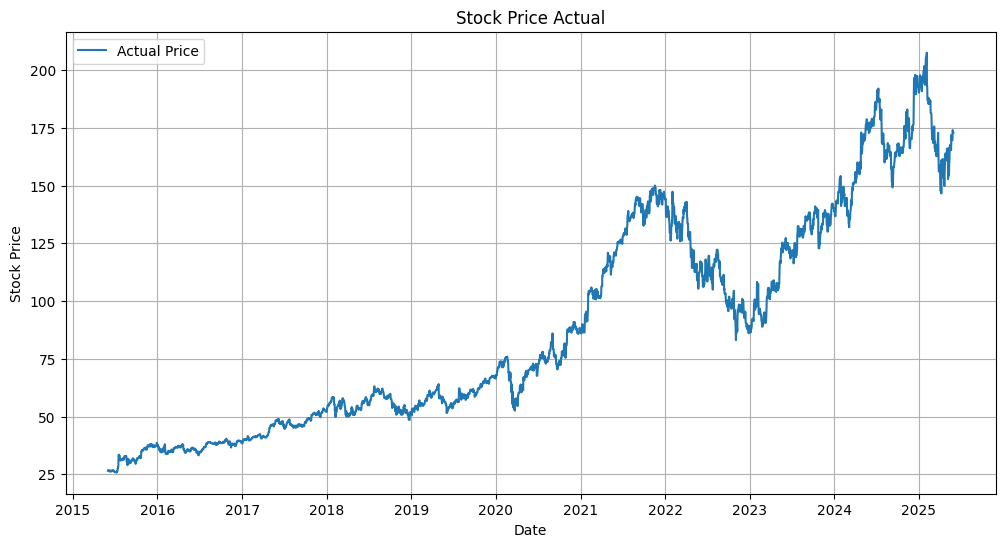

In [ ]:
# Vẽ đồ thị giá thực
dates = data.index[:]
plt.figure(figsize=(12, 6))
plt.plot(dates, close_prices, label='Actual Price')
plt.title('Stock Price Actual')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()


**Step 3**: Implement LSTM

In [ ]:
# Lớp LSTM tùy chỉnh kế thừa từ tf.keras.layers.Layer
class CustomLSTM(tf.keras.layers.Layer):
    def __init__(self, units, return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.units = units  # số lượng đơn vị ẩn (neurons)
        self.return_sequences = return_sequences  # có trả về toàn bộ chuỗi hay chỉ bước cuối

    def build(self, input_shape):
        self.input_dim = input_shape[-1]  # số chiều của đầu vào tại mỗi bước thời gian

        # Ma trận trọng số cho đầu vào x_t
        self.W_f = self.add_weight(shape=(self.input_dim, self.units), initializer="glorot_uniform", name="W_f")  # forget gate
        self.W_i = self.add_weight(shape=(self.input_dim, self.units), initializer="glorot_uniform", name="W_i")  # input gate
        self.W_c = self.add_weight(shape=(self.input_dim, self.units), initializer="glorot_uniform", name="W_c")  # candidate cell
        self.W_o = self.add_weight(shape=(self.input_dim, self.units), initializer="glorot_uniform", name="W_o")  # output gate

        # Ma trận trọng số cho trạng thái ẩn h_t
        self.U_f = self.add_weight(shape=(self.units, self.units), initializer="orthogonal", name="U_f")
        self.U_i = self.add_weight(shape=(self.units, self.units), initializer="orthogonal", name="U_i")
        self.U_c = self.add_weight(shape=(self.units, self.units), initializer="orthogonal", name="U_c")
        self.U_o = self.add_weight(shape=(self.units, self.units), initializer="orthogonal", name="U_o")

        # Các bias cho từng cổng
        self.b_f = self.add_weight(shape=(self.units,), initializer="zeros", name="b_f")
        self.b_i = self.add_weight(shape=(self.units,), initializer="zeros", name="b_i")
        self.b_c = self.add_weight(shape=(self.units,), initializer="zeros", name="b_c")
        self.b_o = self.add_weight(shape=(self.units,), initializer="zeros", name="b_o")

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]      # số lượng mẫu trong batch
        time_steps = inputs.shape[1]          # số bước thời gian (sequence length)
        h_t = tf.zeros((batch_size, self.units))  # khởi tạo trạng thái ẩn ban đầu h_0
        c_t = tf.zeros((batch_size, self.units))  # khởi tạo trạng thái ô nhớ ban đầu c_0
        outputs = []  # lưu tất cả hidden states theo thời gian

        # Duyệt qua từng bước thời gian
        for t in range(time_steps):
            x_t = inputs[:, t, :]  # lấy đầu vào tại thời điểm t

            # Tính toán các cổng
            f_t = tf.sigmoid(tf.matmul(x_t, self.W_f) + tf.matmul(h_t, self.U_f) + self.b_f)  # cổng quên
            i_t = tf.sigmoid(tf.matmul(x_t, self.W_i) + tf.matmul(h_t, self.U_i) + self.b_i)  # cổng đầu vào
            o_t = tf.sigmoid(tf.matmul(x_t, self.W_o) + tf.matmul(h_t, self.U_o) + self.b_o)  # cổng đầu ra
            c_hat_t = tf.tanh(tf.matmul(x_t, self.W_c) + tf.matmul(h_t, self.U_c) + self.b_c)  # giá trị ô nhớ ứng viên

            # Cập nhật trạng thái ô nhớ và trạng thái ẩn
            c_t = f_t * c_t + i_t * c_hat_t  # công thức cập nhật trạng thái ô nhớ
            h_t = o_t * tf.tanh(c_t)         # công thức cập nhật trạng thái ẩn

            outputs.append(h_t)  # lưu trạng thái ẩn hiện tại

        # Kết quả có shape (batch_size, time_steps, units)
        outputs = tf.stack(outputs, axis=1)

        if self.return_sequences:
            return outputs            # trả về toàn bộ chuỗi các trạng thái ẩn
        else:
            return outputs[:, -1, :]  # chỉ trả về trạng thái ẩn cuối cùng (cuối chuỗi)


In [ ]:
# Step 3: Build LSTM model
def build_model(input_shape, units=50):
    model = Sequential() # giúp xếp các lớp
    model.add(CustomLSTM(units, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(CustomLSTM(units, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

**Step 3.2**: Option sử dụng LSTM của thư viện (nhanh hơn) (không chạy đoạn code này khi đã chạy phần Step 3 và ngược lại)


In [ ]:
# Step 3.2: Build LSTM model using library
def build_model(input_shape, units=50):
    model = Sequential() # giúp xếp các lớp
    model.add(LSTM(units, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(units, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

**Step 4**: Tối ưu hóa bằng GA

In [ ]:
# Prepare data
def create_dataset(data, window_size=60): # kích thước của sổ mặc định(nếu không truyền vào thì window_size=60)
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i])
    return np.array(X), np.array(y)

In [ ]:
# Lấy dữ liệu gốc
close_prices = data['Close'].values.reshape(-1, 1)
total_len = len(close_prices)

# Chia theo 80% train, 10% val, 10% test
train_end = int(0.8 * total_len)
val_end = int(0.9 * total_len)

# ⚠️ Giữ lại 90 ngày trước khi chia để đủ cho mọi window_size
max_window_size = 90
train_raw = close_prices[:train_end]
val_raw = close_prices[train_end - max_window_size:val_end]
test_raw = close_prices[val_end - max_window_size:]

# Chuẩn hóa
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_raw)
val_scaled = scaler.transform(val_raw)
test_scaled = scaler.transform(test_raw)


Step 5: Chạy thuật toán HC + SA để tìm ra cá thể tốt nhất

In [ ]:
import random
import copy
import math
from sklearn.metrics import mean_squared_error
import numpy as np
import tensorflow as tf

# ====================================
# 1. Các hàm phụ
# ====================================

def create_individual():
    """
    Tạo một cá thể ngẫu nhiên cho hyperparameter tuning:
      - window_size: int trong [30, 90]
      - units: int trong [32, 64, 128]
    Trả về dict {'window_size': ..., 'units': ...}
    """
    return {
        'window_size': random.randint(30, 90),
        'units': random.choice([32, 64, 128])
    }


def create_neighbor(ind):
    """
    Tạo một cá thể láng giềng (neighbor) từ ind hiện tại.
    Cơ chế đột biến:
      - 50% khả năng thay đổi window_size ±3 hoặc ±5 (giữ trong [30, 90])
      - 50% khả năng đổi sang một giá trị units khác trong [32, 64, 128]
    Trả về dict mới.
    """
    neighbor = copy.deepcopy(ind)
    if random.random() < 0.5:
        delta = random.choice([-5, -3, 3, 5])
        new_ws = neighbor['window_size'] + delta
        neighbor['window_size'] = max(30, min(90, new_ws))
    else:
        choices = [32, 64, 128]
        choices.remove(neighbor['units'])
        neighbor['units'] = random.choice(choices)
    return neighbor


def fitness(ind):
    """
    Tính MSE cho cá thể ind (dict có window_size, units).
    - Giảm epochs xuống 2 để nhanh.
    - Thêm verbose=0 cho model.fit/predict.
    - Nếu dataset trống hoặc có lỗi, trả về inf để phạt.
    """
    ws = ind['window_size']
    units = ind['units']

    try:
        X_train, y_train = create_dataset(train_scaled, ws)
        X_val, y_val     = create_dataset(val_scaled, ws)

        if len(X_train) == 0 or len(X_val) == 0:
            return float('inf')

        # Xây model (đã sửa build_model để khai báo Input layer nếu cần)
        model = build_model((ws, 1), units=units)

        model.fit(X_train, y_train, epochs=2, batch_size=32, verbose=0)
        preds = model.predict(X_val, verbose=0)
        return mean_squared_error(y_val, preds)

    except Exception as e:
        print(f"Warning: fitness failed for {ind}: {e}")
        return float('inf')

# 2. Hàm hill_climb_annealing (HC + SA)

def hill_climb_annealing(max_iterations=100,T_init=1.0,alpha=0.95,min_temperature=1e-3,target_mse=None,random_seed=None):
    """
    Tìm best_hyperparams bằng Hill Climbing + Simulated Annealing.
    Args:
      - max_iterations: số bước neighbor proposals tối đa
      - T_init: nhiệt độ khởi đầu
      - alpha: hệ số giảm nhiệt (0 < alpha < 1)
      - min_temperature: dừng khi T < min_temperature
      - target_mse: nếu không None, dừng khi best_mse <= target_mse
      - random_seed: seed để tái lập kết quả

    Trả về:
      - best_individual: {'window_size', 'units'}
    """
    if random_seed is not None:
        random.seed(random_seed)
        np.random.seed(random_seed)
        tf.random.set_seed(random_seed)

    # Khởi tạo
    current = create_individual()
    current_mse = fitness(current)
    best_individual = copy.deepcopy(current)
    best_mse = current_mse

    T = T_init
    iteration = 0
    print(f"Initial: ws={current['window_size']}, units={current['units']}, MSE={current_mse:.6f}")

    # Vòng lặp chính
    while iteration < max_iterations and T > min_temperature:
        iteration += 1

        neighbor = create_neighbor(current)
        neighbor_mse = fitness(neighbor)

        # Nếu neighbor tốt hơn, accept; ngược lại vẫn có thể accept theo SA
        if neighbor_mse < current_mse:
            accept = True
        else:
            Δ = neighbor_mse - current_mse
            p = math.exp(-Δ / T)
            accept = (random.random() < p)

        if accept:
            current = neighbor
            current_mse = neighbor_mse

            # Cập nhật best nếu cần
            if current_mse < best_mse:
                best_mse = current_mse
                best_individual = copy.deepcopy(current)
                print(f"Iter {iteration:3d}: New best → ws={best_individual['window_size']}, "
                      f"units={best_individual['units']}, MSE={best_mse:.6f}, T={T:.4f}")

        # Giảm nhiệt độ
        T *= alpha

        # Dừng sớm nếu target_mse đã đạt
        if (target_mse is not None) and (best_mse <= target_mse):
            print(f"\nEarly stopping at iter {iteration}: reached target MSE ≤ {target_mse:.6f}")
            break

    print(f"\nFinal best: ws={best_individual['window_size']}, units={best_individual['units']}, MSE={best_mse:.6f}")
    return best_individual

In [ ]:
# HC + SA optimization
best_params = hill_climb_annealing()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Initial: ws=56, units=32, MSE=0.001987


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Iter   3: New best → ws=61, units=32, MSE=0.001448, T=0.9025


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Iter   4: New best → ws=61, units=128, MSE=0.001353, T=0.8574


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Iter   6: New best → ws=61, units=128, MSE=0.001060, T=0.7738


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a l

Iter  75: New best → ws=32, units=128, MSE=0.000968, T=0.0225


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a l


Final best: ws=32, units=128, MSE=0.000968


**Step 6**: Huấn luyện và tính RMSE đối với cá thể tốt nhất được chọn

In [ ]:
from keras.callbacks import EarlyStopping

# 1. Lấy dữ liệu gốc (chưa chuẩn hóa)
close_prices = data['Close'].values.reshape(-1, 1)

# 2. Chia dữ liệu theo tỉ lệ 80% train, 10% val, 10% test
total_len = len(close_prices)
train_end = int(total_len * 0.8)
val_end = int(total_len * 0.9)

train_prices = close_prices[:train_end]
val_prices = close_prices[train_end - best_params['window_size']:val_end]
test_prices = close_prices[val_end - best_params['window_size']:]  # giữ lại window_size ngày

# 3. Fit scaler trên tập train và transform cả 3 phần
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_prices)
scaled_val = scaler.transform(val_prices)
scaled_test = scaler.transform(test_prices)

# 4. Tạo dataset
X_train, y_train = create_dataset(scaled_train, best_params['window_size'])
X_val, y_val = create_dataset(scaled_val, best_params['window_size'])
X_test, y_test = create_dataset(scaled_test, best_params['window_size'])

# 5. Gộp train + val để train mô hình cuối cùng
X_final_train = np.concatenate([X_train, X_val])
y_final_train = np.concatenate([y_train, y_val])

# 6. Xây mô hình
model = build_model((best_params['window_size'], 1), best_params['units'])

# 7. EarlyStopping (monitor trên `loss` vì không có val)
early_stop = EarlyStopping(
    monitor='loss',
    patience=5,
    restore_best_weights=True
)

# 8. Huấn luyện trên train + val
model.fit(
    X_final_train, y_final_train,
    epochs=100,
    batch_size=32,
    verbose=1,
    callbacks=[early_stop]
)

# 9. Dự đoán trên test set và tính RMSE
preds = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("✅ Test RMSE:", rmse)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


102/102 ━━━━━━━━━━━━━━━━━━━━ 13s 94ms/step - loss: 0.0292
Epoch 2/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - loss: 0.0026
Epoch 3/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - loss: 0.0018
Epoch 4/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - loss: 0.0016
Epoch 5/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 11s 91ms/step - loss: 0.0018
Epoch 6/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - loss: 0.0019
Epoch 7/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - loss: 0.0018
Epoch 8/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - loss: 0.0017
Epoch 9/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - loss: 0.0016
Epoch 10/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - loss: 0.0016
Epoch 11/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 11s 93ms/step - loss: 0.0014
Epoch 12/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - loss: 0.0014
Epoch 13/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - loss: 0.0014
Epoch 14/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - loss: 0.0014
Epoch 15/100
102/102 ━━━━━━━━━

91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


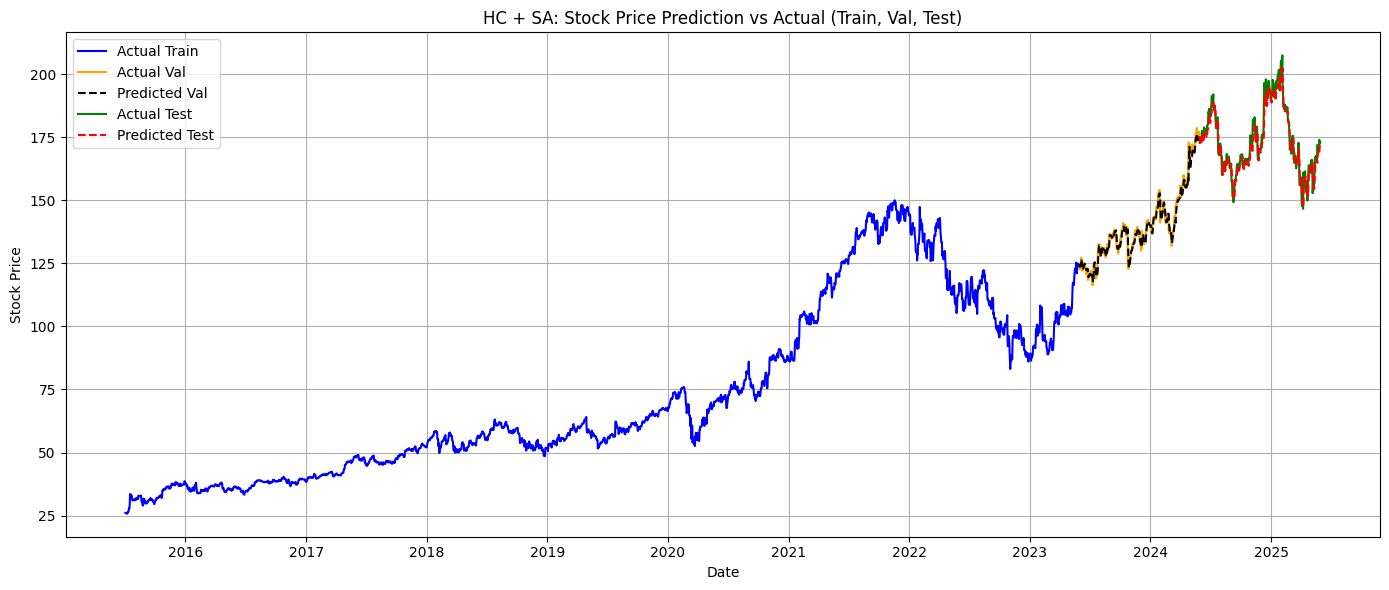

In [ ]:
# Dự đoán từng phần
train_preds = model.predict(X_train)
val_preds = model.predict(X_val)
test_preds = model.predict(X_test)

# Inverse transform các phần
y_train_rescaled = scaler.inverse_transform(y_train)
train_preds_rescaled = scaler.inverse_transform(train_preds)

y_val_rescaled = scaler.inverse_transform(y_val)
val_preds_rescaled = scaler.inverse_transform(val_preds)

y_test_rescaled = scaler.inverse_transform(y_test)
test_preds_rescaled = scaler.inverse_transform(test_preds)

# Lấy index ngày tương ứng
train_start = best_params['window_size']
val_start = train_end
test_start = val_end

train_dates = data.index[train_start:train_start + len(y_train)]
val_dates = data.index[val_start:val_start + len(y_val)]
test_dates = data.index[test_start:test_start + len(y_test)]

# Vẽ biểu đồ chung
plt.figure(figsize=(14, 6))
plt.plot(train_dates, y_train_rescaled, label='Actual Train', color='blue')
#plt.plot(train_dates, train_preds_rescaled, label='Predicted Train', color='black', linestyle='--')

plt.plot(val_dates, y_val_rescaled, label='Actual Val', color='orange')
plt.plot(val_dates, val_preds_rescaled, label='Predicted Val', color='black', linestyle='--')

plt.plot(test_dates, y_test_rescaled, label='Actual Test', color='green')
plt.plot(test_dates, test_preds_rescaled, label='Predicted Test', color='red', linestyle='--')

plt.title('HC + SA: Stock Price Prediction vs Actual (Train, Val, Test)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step
Độ sai số trung bình trên tập validation: 1.572670735398384 dolar


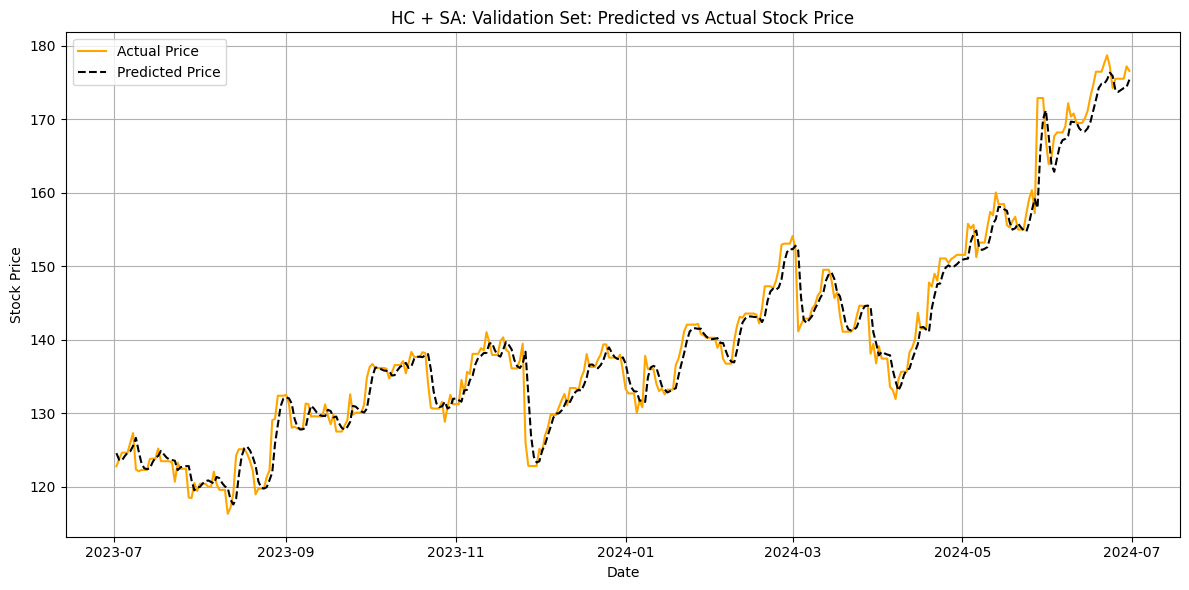

In [ ]:
# Dự đoán trên tập validation
val_preds = model.predict(X_val)

# Inverse transform y_val và dự đoán
y_val_rescaled = scaler.inverse_transform(y_val)
val_preds_rescaled = scaler.inverse_transform(val_preds)

# MAE trên tập validation
val_mae = np.mean(np.abs(y_val_rescaled - val_preds_rescaled))
print("Độ sai số trung bình trên tập validation:", val_mae, "dolar")

# Lấy index ngày đúng cho tập validation
val_start_index = train_end + best_params['window_size']
val_dates = data.index[val_start_index : val_start_index + len(y_val)]

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(val_dates, y_val_rescaled, label='Actual Price', color='orange')
plt.plot(val_dates, val_preds_rescaled, label='Predicted Price', color='black', linestyle='--')
plt.title('HC + SA: Validation Set: Predicted vs Actual Stock Price')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Độ sai số trung bình trên tập test: 2.431582174665941 dolar
MAPE trên tập test: 1.39%


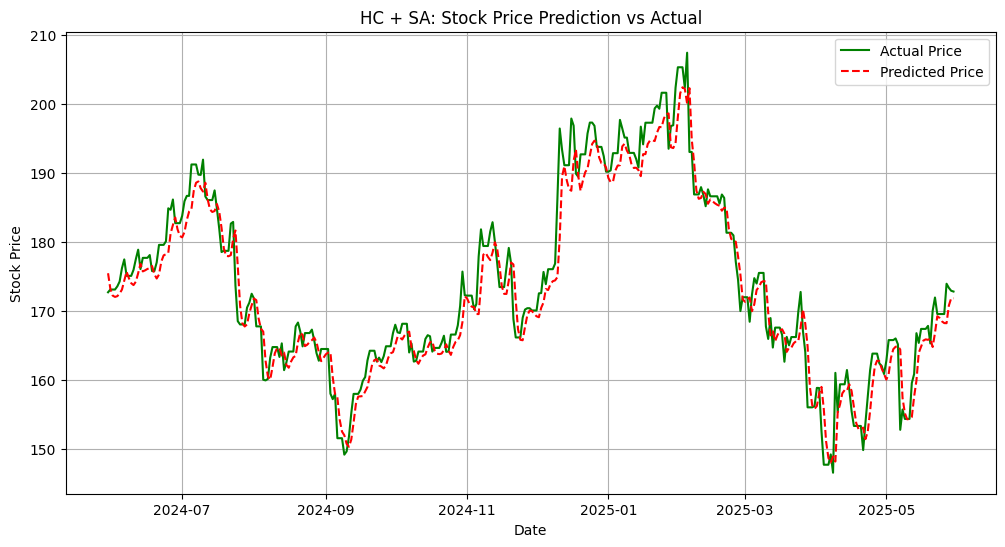

In [ ]:
# Plot predictions vs actual
y_test_rescaled = scaler.inverse_transform(y_test)
preds_rescaled = scaler.inverse_transform(preds)
mae = np.mean(np.abs(y_test_rescaled- preds_rescaled))
print("Độ sai số trung bình trên tập test:", mae, "dolar")
mape = np.mean(np.abs((y_test_rescaled - preds_rescaled) / y_test_rescaled)) * 100 # Tỷ lệ phần trăm sai số trung bình
print(f"MAPE trên tập test: {mape:.2f}%")
# Get the corresponding dates for the last 100 entries (the test set)
dates = data.index[-len(y_test):]  # data is the original DataFrame from yfinance
plt.figure(figsize=(12, 6))
plt.plot(dates, y_test_rescaled, label='Actual Price', color='green')
plt.plot(dates, preds_rescaled, label='Predicted Price', color='red', linestyle='--')
plt.title('HC + SA: Stock Price Prediction vs Actual')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()


**Step 8**: Vẽ đồ thị 100 ngày gần nhất

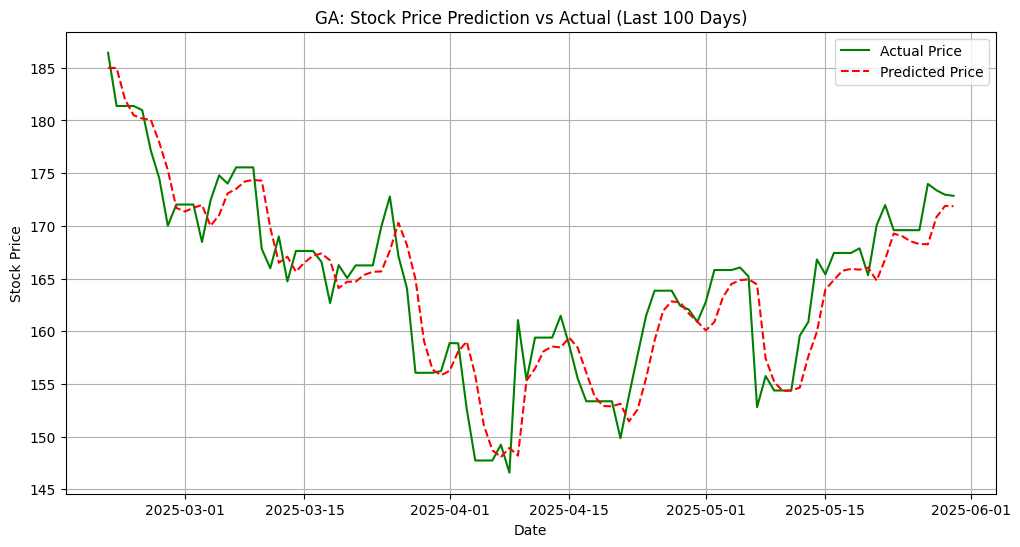

In [ ]:
# Chỉ lấy 100 mẫu cuối cùng
num_plot = 100
y_test_subset = y_test[-num_plot:]
preds_subset = preds[-num_plot:]

# Biến đổi ngược lại giá gốc
y_test_rescaled = scaler.inverse_transform(y_test_subset)
preds_rescaled = scaler.inverse_transform(preds_subset)

# Lấy đúng 100 ngày cuối tương ứng trong dữ liệu gốc
dates = data.index[-num_plot:]

# Vẽ đồ thị
plt.figure(figsize=(12, 6))
plt.plot(dates, y_test_rescaled, label='Actual Price', color='green')
plt.plot(dates, preds_rescaled, label='Predicted Price', color='red', linestyle='--')
plt.title('GA: Stock Price Prediction vs Actual (Last 100 Days)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()


**Step 9:** Dự đoán giá những ngày sau đó (Chưa có dữ liệu thực)



In [ ]:
def predict_next_days(model, last_sequence, days_to_predict=30, scaler=None):
    """
    Dự đoán `days_to_predict` ngày tiếp theo dựa vào chuỗi đầu vào `last_sequence`.
    Trả về danh sách các giá trị thực tế (đã inverse_transform nếu cần).
    """
    predicted = []
    current_input = last_sequence.reshape(1, last_sequence.shape[0], 1)

    for _ in range(days_to_predict):
        next_price = model.predict(current_input, verbose=0)[0][0]
        predicted.append(next_price)
        current_input = np.append(current_input[:, 1:, :], [[[next_price]]], axis=1)

    if scaler:
        predicted = scaler.inverse_transform(np.array(predicted).reshape(-1, 1)).flatten()

    return predicted


In [ ]:
# Lấy ngày cuối cùng trong dữ liệu yfinance
last_date = data.index[-1]

# Tạo 30 ngày làm việc tiếp theo (bỏ cuối tuần)
future_dates = pd.bdate_range(start=last_date + pd.Timedelta(days=1), periods=30)


In [ ]:
# Lấy chuỗi gần nhất
last_sequence = scaled_test[-best_params['window_size']:]

# Dự đoán 30 ngày tới
predicted_prices = predict_next_days(model, last_sequence, days_to_predict=30, scaler=scaler)

# In kết quả theo ngày
for date, price in zip(future_dates, predicted_prices):
    print(f"{date.strftime('%Y-%m-%d')}: {price:.2f}")


2025-06-02: 171.59
2025-06-03: 170.73
2025-06-04: 169.87
2025-06-05: 169.11
2025-06-06: 168.48
2025-06-09: 167.95
2025-06-10: 167.52
2025-06-11: 167.14
2025-06-12: 166.80
2025-06-13: 166.47
2025-06-16: 166.15
2025-06-17: 165.82
2025-06-18: 165.49
2025-06-19: 165.16
2025-06-20: 164.82
2025-06-23: 164.48
2025-06-24: 164.14
2025-06-25: 163.81
2025-06-26: 163.48
2025-06-27: 163.16
2025-06-30: 162.84
2025-07-01: 162.53
2025-07-02: 162.23
2025-07-03: 161.93
2025-07-04: 161.64
2025-07-07: 161.35
2025-07-08: 161.07
2025-07-09: 160.79
2025-07-10: 160.51
2025-07-11: 160.24


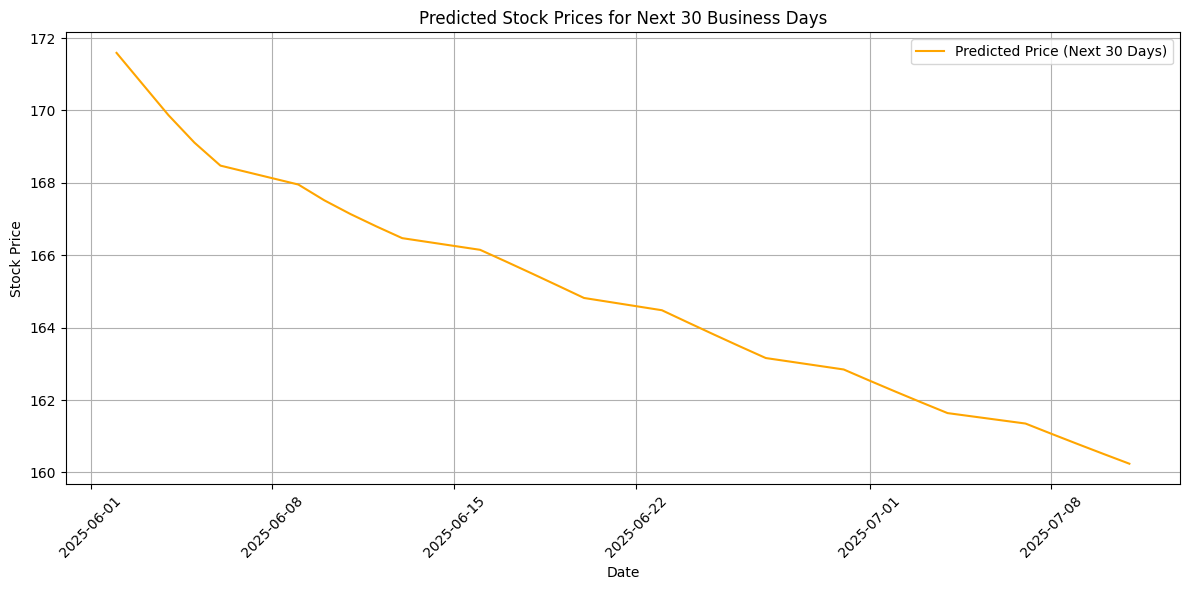

In [ ]:
# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(future_dates, predicted_prices, label='Predicted Price (Next 30 Days)', color='orange')
plt.title('Predicted Stock Prices for Next 30 Business Days')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


**Step 10**: Thêm vòng for để dự đoán nhiều loại cổ phiếu (Code y như phần dự đoán 1 cổ phiếu chỉ thêm vòng for)

In [ ]:
symbols = ["AAPL", "GOOG", "MSFT", "AMZN"]

In [ ]:
for symbol in symbols:
    print(f"\n========= Processing {symbol} =========")

    # code này y như phần trên
    #1. Tiền xử lí
    data = download_stock_data(symbol)
    data = data.asfreq('D')
    data = data.fillna(method='ffill')
    # Tìm giá trị tối ưu
    best_params = genetic_algorithm()
    print("Best Parameters from GA:", best_params)

    # 2. Chia dữ liệu trước khi scale
    split_index = int(len(close_prices) * 0.8)
    train_prices = close_prices[:split_index]
    test_prices = close_prices[split_index - best_params['window_size']:]

    # 3. Fit scaler trên tập train và transform cả hai phần
    scaler = MinMaxScaler()
    scaled_train = scaler.fit_transform(train_prices)
    scaled_test = scaler.transform(test_prices)

    # 4. Tạo dataset
    X_train_final, y_train_final = create_dataset(scaled_train, best_params['window_size'])
    X_test, y_test = create_dataset(scaled_test, best_params['window_size'])

    model = build_model((best_params['window_size'], 1), best_params['units'])
    model.fit(X_train_final, y_train_final, epochs=30, batch_size=32, verbose=1)
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    print("Test RMSE:", rmse)

    y_test_rescaled = scaler.inverse_transform(y_test)
    preds_rescaled = scaler.inverse_transform(preds)
    dates = data.index[-len(y_test):]

    plt.figure(figsize=(12, 6))
    plt.plot(dates, y_test_rescaled, label='Actual Price')
    plt.plot(dates, preds_rescaled, label='Predicted Price')
    plt.title(f'{symbol} Stock Price Prediction vs Actual')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.grid(True)
    plt.show()
